In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.svm import SVC
from scipy import stats
import seaborn as sns
import numpy as np

In [2]:
train_df = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/train.csv")
seg_id = train_df['segment_id'][0]
df_seg_id = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/fft_stats/"+str(seg_id)+".csv")


## Analyzing seismic data for detection systems. 

 

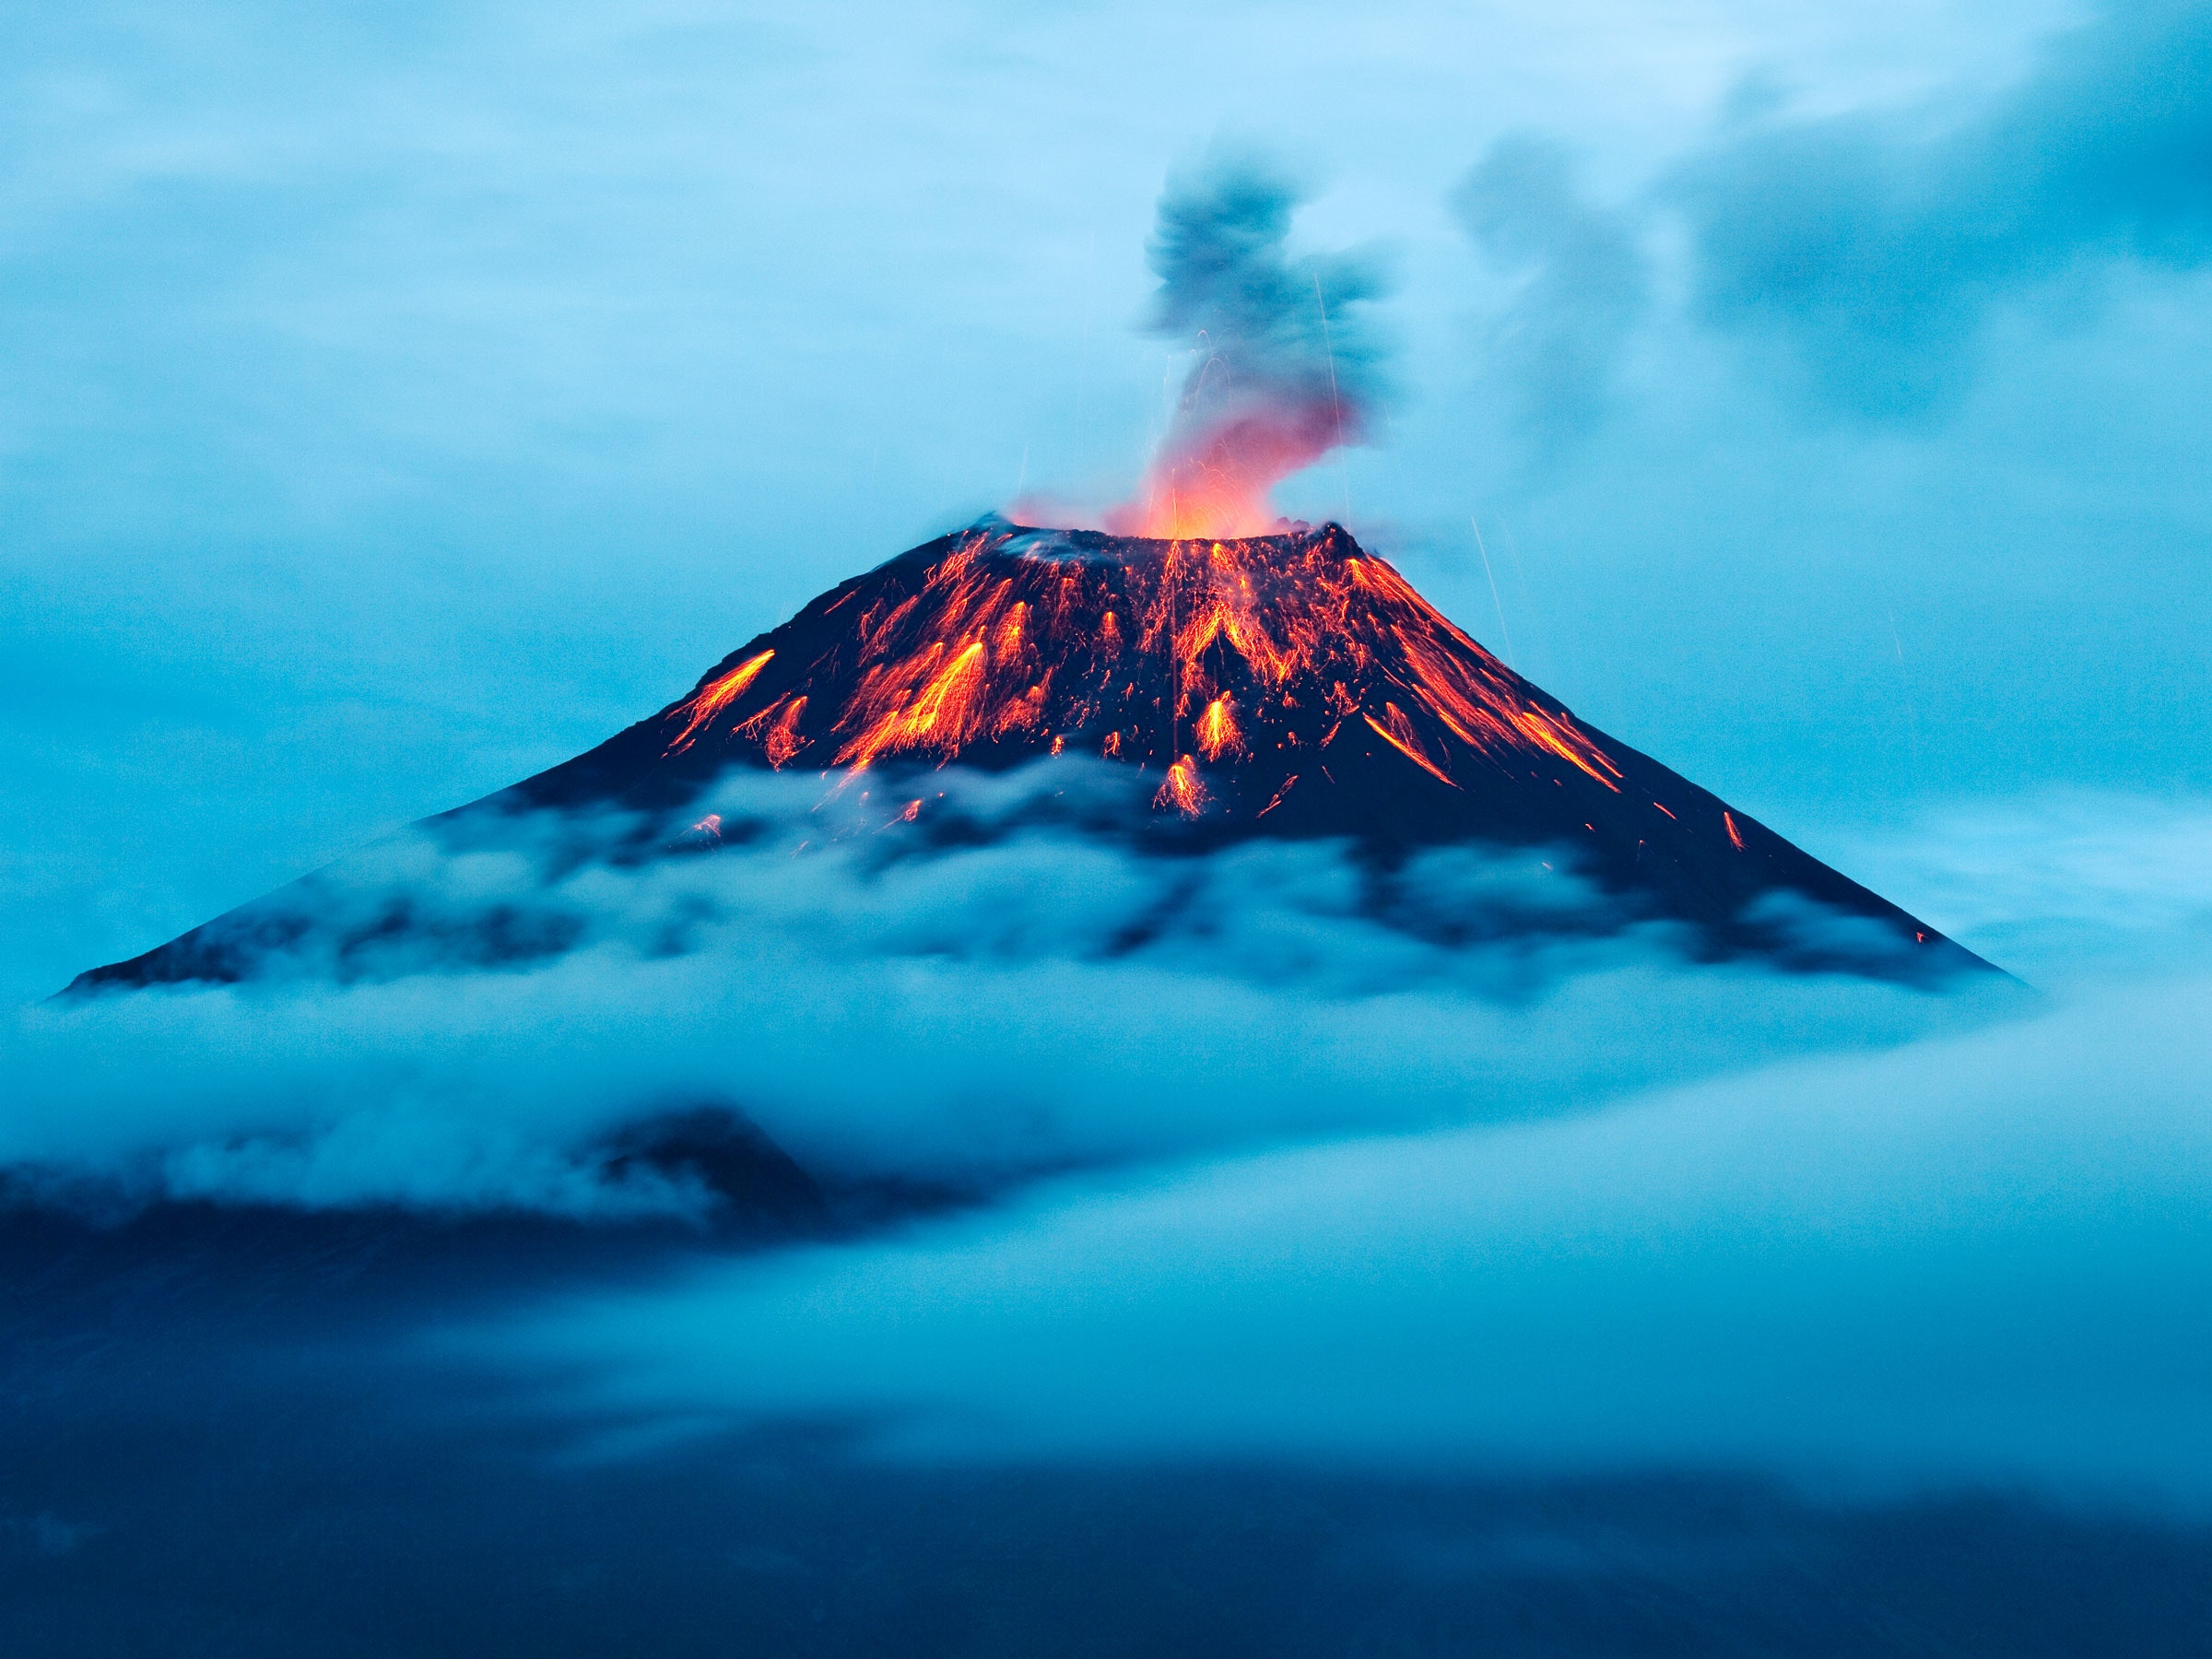

## Introduction
In this project we will investigate whether we can interpret seismic activity of a volcano to predict eruptions within a timeframe (0-2 day, 2-4 days, 4-5 days). Seismic activity in this project refers to the tremors and earthquakes that occur within a close range to a volcano (within 10km, of the surface). Usually an eruption is preceded by dozens to hundreds of seismic events[1].

In our study, we have a curated dataset of seismic activity readings from 10 sensors at unspecified locations around a volcano. Each set of reading contains 10 mins of data form each sensor.

The ability to interpret seismic data as to predict a time to eruption would of course be beneficial toward disaster management. 

#### Figure A: Seismic sensor data
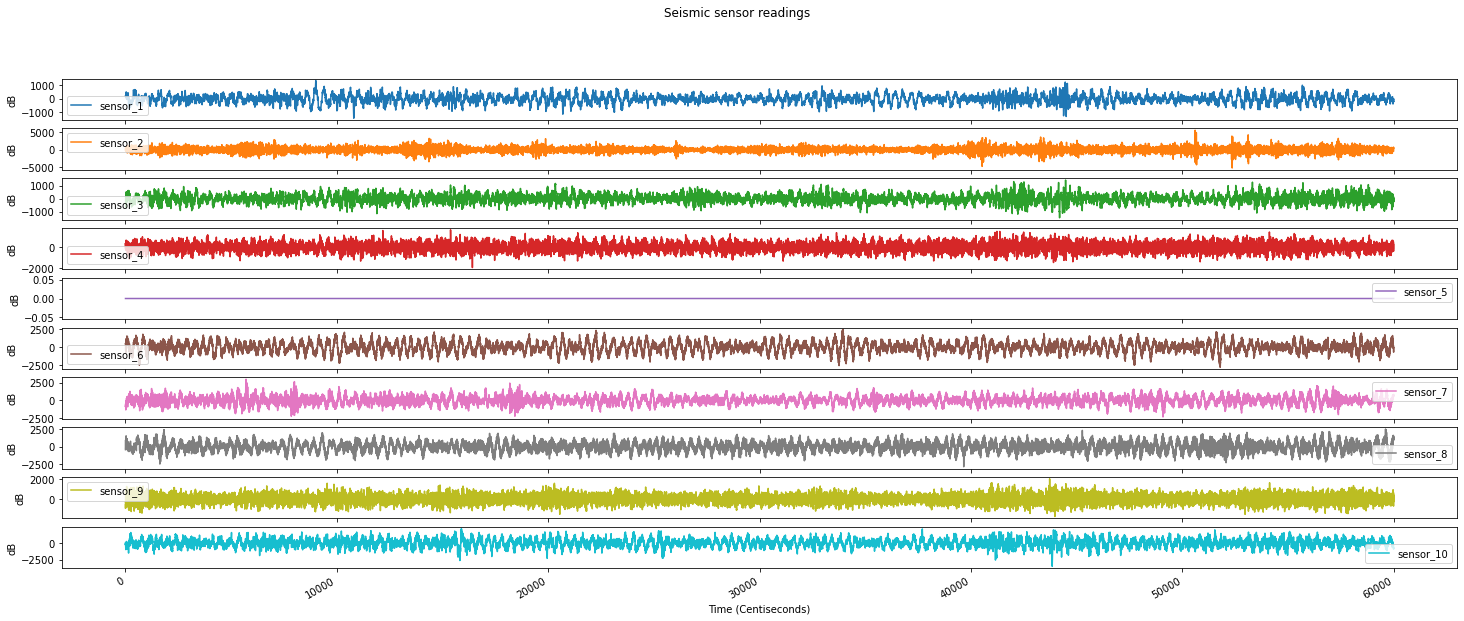

In [ ]:
df_seg_id.fillna(0).plot(subplots=True, figsize=(25, 10), title='Seismic sensor readings', xlabel='Time (Centiseconds)', ylabel='dB')  ############ Figure A: Sesmic sensor data

### Data specification
We use a publicly available dataset distributed by Kaggle, which is provided by the The National Institute of Geophysics and Volcanology, a research institute in Italy. 
Downloaded the data from: https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/data

We are restricted as to precise data collection methods and metadata from the sensors. We have only been provided raw seismic data from 10 unspecified location around a volcano. However we were able to establish that the dataset some from monitored events around Mt. Etna.  

Image A:"Figure 1, A. Bonaccorso (2008)" [2]
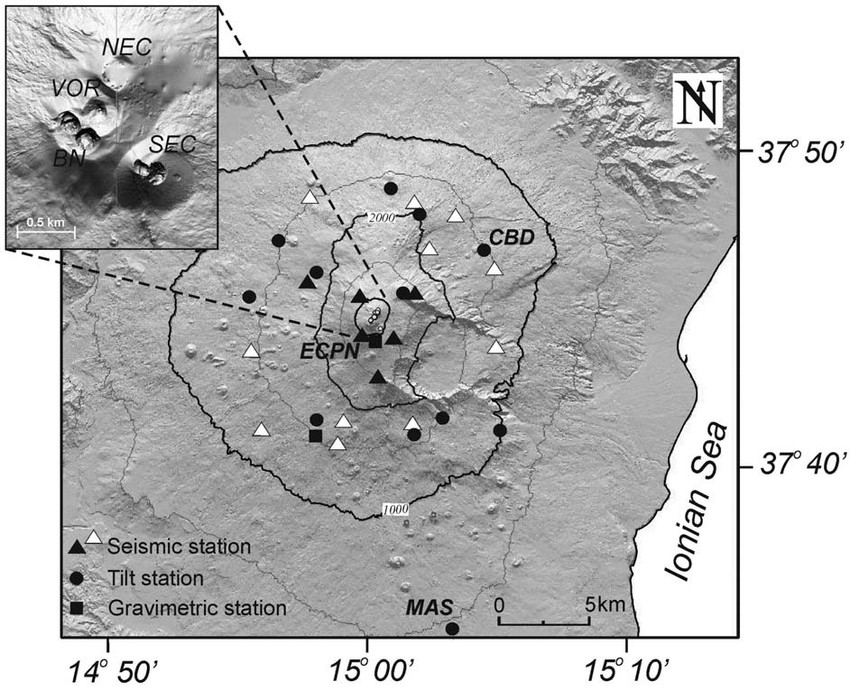
Digital elevation model of Mount Etna with seismic stations used to locate volcanic tremor (black and white triangles) and LP events (black triangles), tiltmeters (black dots), and gravimeters (black squares) used in this work. The inset in the top left corner shows the distribution of the four summit craters (VOR, Voragine; BN, Bocca Nuova; SEC, Southeast Crater; NEC, Northeast Crater).


The data we analyze in this project, we assume, is that collected from seismic sensors that monitor 'Long Period Events'(LP). LP events are low frequencies emitted from volcano-related earthquakes and is typically used to predict eruptions[4]. Our dataset contains a reading from 10 sensors recording in parallel from such LP sensors around a volcano. Figure C shows in subplot C, the timeframe of recorded data leading to an eruption. Our dataset set contains reading between 1 and 5 days preceding an earthquake. 

Image 2: "Figure 8, A. Bonaccorso (2008)" [2]:
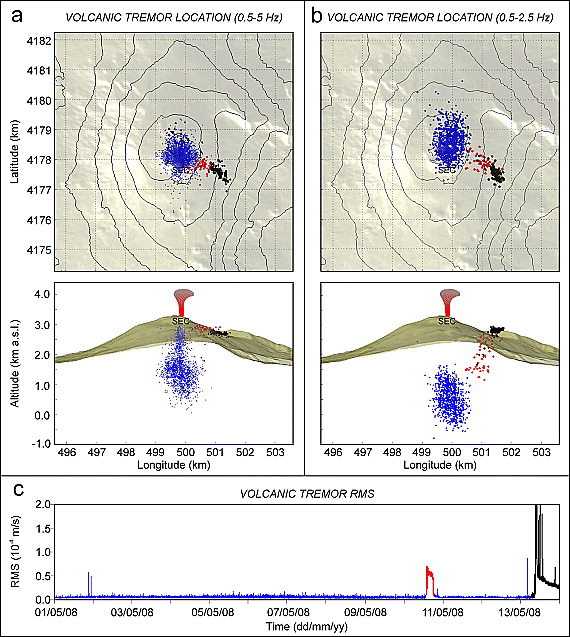
(a) WB and (b) NB volcanic tremor source locations in map view and cross section and (c) RMS during 1–13 May 2008. The colors of the dots in Figures 8a and 8b indicate the different time intervals of the locations, also reported in the RMS time series. In particular, the red, black, and blue dots indicate the tremor source locations during the 10 May lava fountain, the very first days of the 2008–2009 eruption, and the remaining period, respectively.

#### Seismic data file analysis
Each seismic data file, contains 10 sensor readings each a the length of 60,000 timesteps. The frequency of the sample rate is assumed at 100Hz, and therefore the segment time is 10 minutes. The X axis is time and the y axis is amplitude. The figure below shows a plot of one sensor reading from a segment_id.csv file.

Figure B:

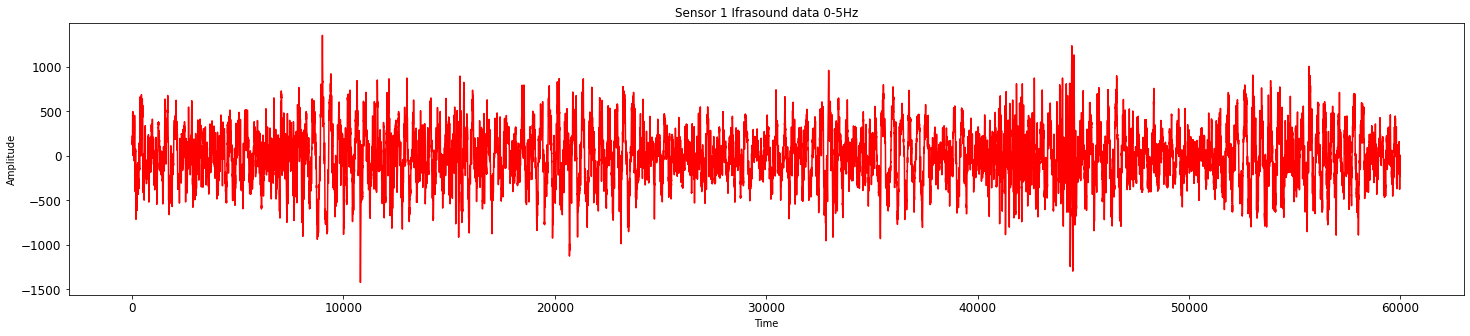

AttributeError: 'Line2D' object has no property 'xlabel'

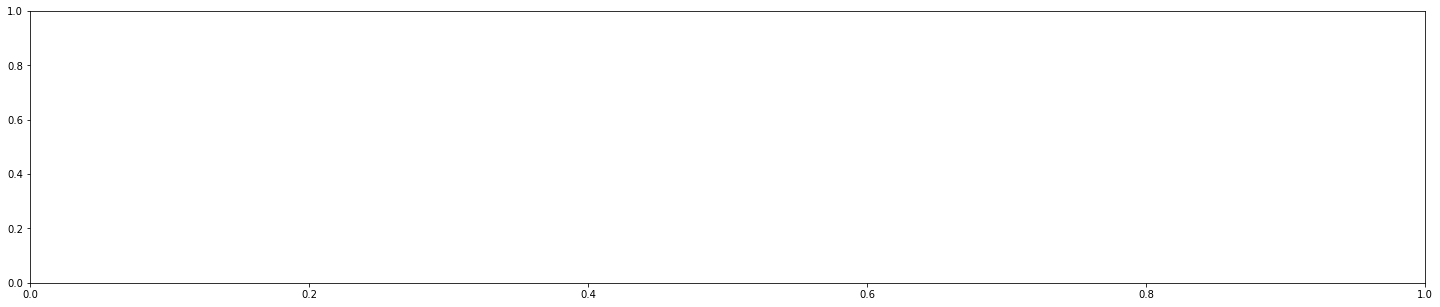

In [7]:
sensor_1 = df_seg_id['sensor_1']
sensor_1.plot(figsize=(25, 5), color='red', xlabel='Time', ylabel='Amplitude', fontsize=12, title='Figure B: Sensor 1 Ifrasound data 0-5Hz')

Some sensor readings for in some segments have no data, shown below as NaN. This data is filled with Zeros. 

In [ ]:
df_seg_id.head()

The downloaded dataset has also following file of interest, **train.csv** which contains the name of a seismic data file labelled 'segment_id' and it's respective time to eruption metadata measured in Centiseconds (1/100th of a second).

#### Train.csv 

a) segment_id (Discrete): ID code for the data segment. Matches the name of an associated .csv data file containing 10  minutes of logs from 10 different sensors configured around a volcano. The readings have been normalized within each segment.

b) time_to_eruption (Continuous): Time to eruption-the time until the next eruption(in centiseconds - 1/100th of a second). The range of time to eruption is up to 5 days.


In [8]:
# train.csv containing the segment_ids and time_of_eruption
train_df = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/train.csv")

# Added new column to display days_to_eruption by converting time in centiseconds to days
train_df['days_to_eruption']=train_df['time_to_eruption']/(100*60*60*24)
train_df.tail()
# Plotting the histogram with time to eruption data

,segment_id,time_to_eruption,days_to_eruption
4426,873340274,15695097,1.816562
4427,1297437712,35659379,4.127243
4428,694853998,31206935,3.611914
4429,1886987043,9598270,1.110911
4430,1100632800,20128938,2.329738


Text(0.5, 1.0, 'Figure C: Distrubution of Eruption times')

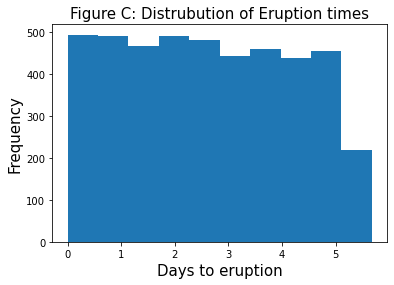

In [9]:
fig = plt.hist(train_df["days_to_eruption"], bins=10)
plt.xlabel('Days to eruption', size=15)
plt.ylabel('Frequency', size=15)
plt.title('Figure C: Distrubution of Eruption times', size=15)

### 1.4 Put a testing set aside and do not look at it before you test your model. Split the rest of the data into a training set and a validation set. 

In [55]:
# Put a testing set aside and do not look at it before you test your model. 
# Split the rest of the data into a training set and a validation set.

# First split data to train, test and then split train again into validation and train.
df_consolidated = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/fft_stats/dataset.csv",index_col=0)
X = df_consolidated
y = df_consolidated['time_to_eruption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train),len(X_test))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)  
print(len(X_train),len(X_val),len(X_test))

3544 887
2835 709 887


In [56]:
X_train['sensor_1_mean']

1317    21675.277010
2451    21306.513498
2621    21912.961043
3002    33599.982497
3870    32429.747716
            ...     
4393    23025.443338
3972    20108.388685
2418    22695.473698
987     64538.220536
2692    28717.357690
Name: sensor_1_mean, Length: 2835, dtype: float64

### 1.5 Do they follow the same distribution? Use a Q-Q plot to show their relations. 
Figure D: Distrubution Train and Validation sets

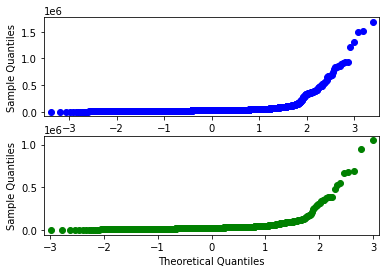

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(6,4))
X_train['sensor_1_mean']
sm.qqplot(X_train['sensor_1_mean'],ax=ax[0])
sm.qqplot(X_val['sensor_1_mean'],ax=ax[1], color="green")
#sm.qqplot(X_test['sensor_1_mean'],ax=ax[1], color="red")
plt.show()

## 2. Define a problem
In this problem we are aiming to classify the time to eruption intervals into less than two days, between two to four days or more than 4 days given the sound signals received from the sensors configured around Mount Etna. 

## 3. Descriptive analysis


In [7]:
fig = plt.hist(sensor_1, bins=100)

plt.xlabel('Amplitude', size=15)
plt.ylabel('Count', size=15)
plt.title('Figure E: Frequency of Amplitude over a 10 min segment')
plt.show()

NameError: name 'sensor_1' is not defined

### 3.1 Show the histogram of some selected variables and describe what you conclude.


#### Sensor readings
The sensor data, shown in Figure D, plotted as a histogram below that the over the 10 minute segment a gaussian distribution of the amplitude is observed. This is expected as we notice that over the segment some LP event is captured.
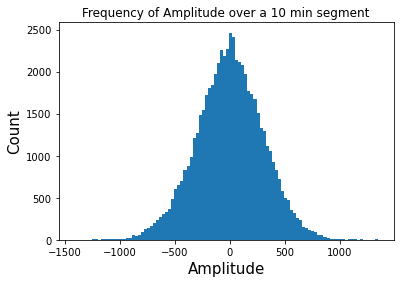



The Figure below shows the frequency of amplitude of all sensors in a 10 minute segment file.
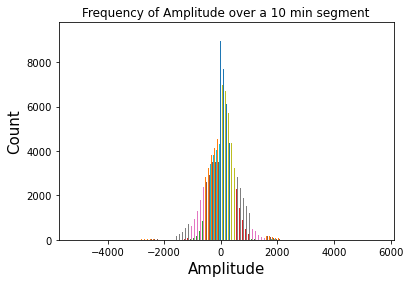

Visualizing a group on sensors as violin plots, we can observe the individual distributions of amplitude for all sensors. 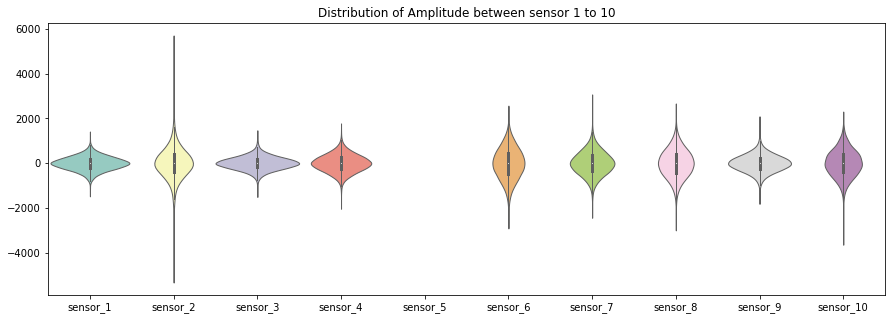

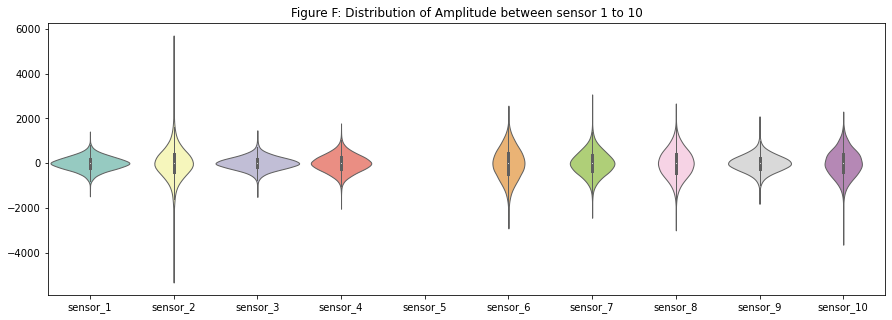

In [60]:
plt.figure(figsize=(15,5))
plt.title('Figure F: Distribution of Amplitude between sensor 1 to 10')
fig = sns.violinplot(data=df_seg_id, palette="Set3", bw=.2, cut=1, linewidth=1, width=1)


### 3.2 Show the dependence of some selected variables and describe what you conclude.
####  Correlation between sensors
Our raw dataset contains 10 sensors per segment data file, and where each sensor contains 60,000 data points. The visualization of the data is shown in Figure A.  
We want to know if there is a correlation between the sensors, with the purpose to find out of some sensor recording the same data. We start with plotting the raw data and find that there is no apparent correlation between sensors. This is somewhat unexpected that all sensors so near zero correlation figures. 

In [15]:
all_data = []
#fft_raw_data2 = pd.DataFrame()
for i in range(0,100):
    seg_id = train_df['segment_id'][i]
    
    all_data.append(pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/fft_stats/"+str(seg_id)+".csv", index_col=0))
result = pd.concat(all_data, axis=0)
fig = plt.figure(figsize=(10,7))
plt.title('Figure G: Correlation of raw sensor data over a 10 min segment')

sns.heatmap(result.corr(method='spearman'),annot=True,fmt=".2f");

FileNotFoundError: [Errno 2] File ../../predict-volcanic-eruptions-ingv-oe/fft_stats/1969647810.csv does not exist: '../../predict-volcanic-eruptions-ingv-oe/fft_stats/1969647810.csv'

#### Correlation of raw sensor data over a 10 min segment
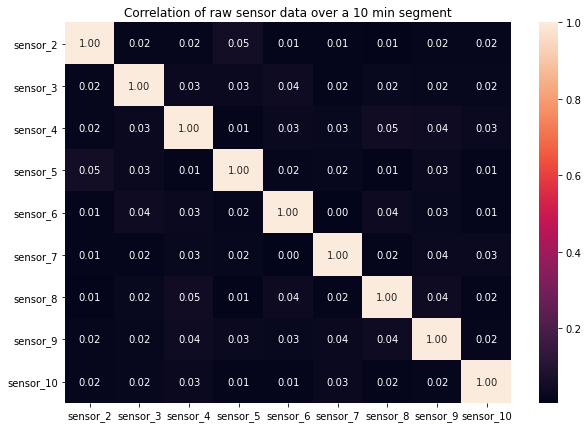

The raw in this form however, may not be the best representation of our input data to model. The seismic data has captured the frequency of the infrasound, to visualize we should transform our data. To do this we use a Short-time Fourier transform (STFT) apply 100Hz as the sampling frequency. What we observe is a constant low frequency emission which we are interested in 0-5Hz typical of LP events. The higher frequencies, we assume to be noise data.
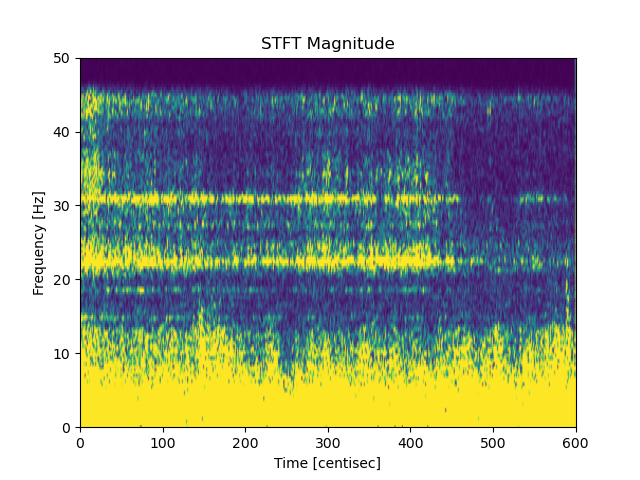



We will transform our data from time to frequency using FFT which will look at the entire 10 min sequence. 
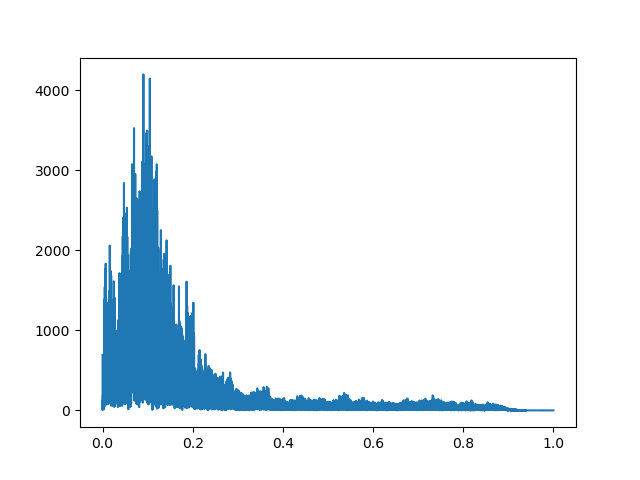

#### Correlation of FTT sensor data over a 10 min segment

We the assume that rather than to observe the amplitude over time, given in the raw data; we can observe the frequency and amplitude. Figure H, below, shows the correlation between sensors taking frequency in account. This shows a higher degree of correlation between some sensors of an average reading of 100 segments. 

In [16]:
# Reading the first segment id file containing sensor data and plotting heatmap

seg_id = train_df['segment_id'][0]
fft_raw_data = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/fft_train/"+str(seg_id)+".csv", index_col=0)

all_data = []
#fft_raw_data2 = pd.DataFrame()
for i in range(0,100):
    seg_id = train_df['segment_id'][i]
    
    all_data.append(pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/fft_train/"+str(seg_id)+".csv", index_col=0))
result = pd.concat(all_data, axis=0)
fig = plt.figure(figsize=(10,7))
plt.title('Figure H: Correlation of FTT sensor data over a 10 min segment')

sns.heatmap(result.corr(),annot=True,fmt=".2f");

FileNotFoundError: [Errno 2] File ../../predict-volcanic-eruptions-ingv-oe/fft_train/1136037770.csv does not exist: '../../predict-volcanic-eruptions-ingv-oe/fft_train/1136037770.csv'

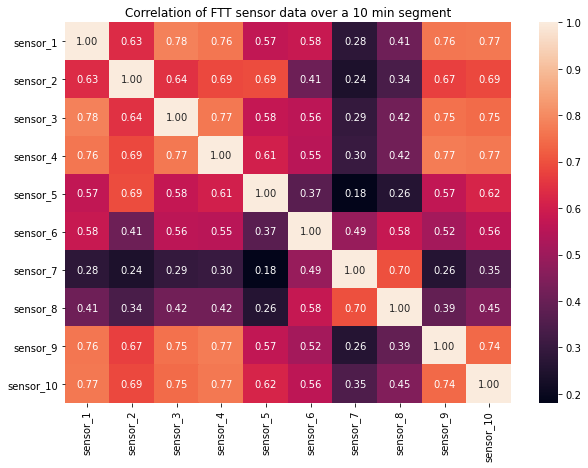

### 3.3 Describe the data using its range, sample mean, sample standard deviation and some quantiles.
#### Data preprocessing
We have processed our data  using:
pipe_fft.py : Performs Fast-Fourier Transform on raw data.

pipe_data_stats.py : Reduces data 60,000 per sensor to collected the mean and std of each segment. 

The out of the pipe is labeled as dataset.csv and is separated in training set X_train and validation set y_train:


In [8]:
X_train.head() 

,segment_id,time_to_eruption,sensor_1_mean,sensor_1_std,sensor_2_mean,sensor_2_std,sensor_3_mean,sensor_3_std,sensor_4_mean,sensor_4_std,...,sensor_6_mean,sensor_6_std,sensor_7_mean,sensor_7_std,sensor_8_mean,sensor_8_std,sensor_9_mean,sensor_9_std,sensor_10_mean,sensor_10_std
1790,889075076,39801686,16039.997833,70755.380268,29211.306094,60230.861980,13494.474925,58656.674351,17474.616471,60428.791448,...,22346.097429,113581.774025,14998.664322,83027.090593,34152.381656,111162.758784,14641.588929,52257.082939,33470.753716,123243.159232
89,349291703,14964357,32385.687135,79092.952364,66314.172455,95333.572134,131845.073950,295931.237539,33016.057479,75267.745379,...,74335.311723,149327.614702,67497.958296,121698.799522,55552.649940,147924.758249,46177.616189,72839.688554,72115.372651,170880.973078
3188,611606940,2903621,25903.525368,98461.649931,91254.193520,231902.941418,22701.140414,70562.126209,28676.653907,81691.406792,...,34720.973349,51928.414655,28863.790137,72957.419955,44988.402035,68033.895667,29648.051220,95359.955652,74179.666526,255512.151542
2753,128130872,6044494,37266.360657,121719.866242,170075.244731,367009.665842,34495.977445,111680.788766,57658.841439,146735.701733,...,45368.116946,159851.105919,58806.765630,117874.672760,50884.963715,91715.305578,86433.414262,134578.838521,77770.435693,244803.750055
3479,527014367,40436272,23257.821096,78530.430076,0.000000,0.000000,21149.095280,68628.123291,27688.865241,72165.873339,...,34422.132121,147996.946924,18691.639887,95027.318693,34353.019376,114589.937912,25098.560560,70096.931512,47340.958505,145816.157539


In [9]:
X_train.describe()

,segment_id,time_to_eruption,sensor_1_mean,sensor_1_std,sensor_2_mean,sensor_2_std,sensor_3_mean,sensor_3_std,sensor_4_mean,sensor_4_std,...,sensor_6_mean,sensor_6_std,sensor_7_mean,sensor_7_std,sensor_8_mean,sensor_8_std,sensor_9_mean,sensor_9_std,sensor_10_mean,sensor_10_std
count,2.835000e+03,2.835000e+03,2.835000e+03,2.835000e+03,2.835000e+03,2.835000e+03,2.835000e+03,2.835000e+03,2.835000e+03,2.835000e+03,...,2.835000e+03,2.835000e+03,2835.000000,2.835000e+03,2835.000000,2.835000e+03,2.835000e+03,2.835000e+03,2.835000e+03,2.835000e+03
mean,1.061127e+09,2.284583e+07,4.715005e+04,1.538496e+05,1.007486e+05,2.170956e+05,3.987296e+04,1.401163e+05,5.212550e+04,1.498486e+05,...,6.036220e+04,1.890420e+05,42460.358879,1.193965e+05,43779.967783,1.239507e+05,5.024847e+04,1.537725e+05,7.626815e+04,2.502317e+05
std,6.114139e+08,1.358739e+07,9.953118e+04,3.757286e+05,1.596574e+05,4.116257e+05,8.836422e+04,3.546885e+05,9.381488e+04,3.429147e+05,...,5.865358e+04,3.078286e+05,41505.454516,1.844271e+05,38586.340098,1.741084e+05,1.040575e+05,3.926572e+05,1.230869e+05,4.444657e+05
min,5.131810e+05,6.250000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.014986e+04,2.243261e+04,...,1.036785e+04,3.942297e+04,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.496579e+08,1.105432e+07,2.068264e+04,6.304545e+04,4.523750e+04,8.758869e+04,1.721498e+04,4.948590e+04,2.509697e+04,6.298774e+04,...,3.014636e+04,7.782290e+04,18862.352175,6.863927e+04,23617.465950,6.202490e+04,2.351007e+04,6.246813e+04,4.496780e+04,1.333545e+05
50%,1.048074e+09,2.260924e+07,2.631142e+04,8.233874e+04,6.647058e+04,1.213025e+05,2.276836e+04,6.992771e+04,3.267735e+04,7.834756e+04,...,4.426537e+04,1.281776e+05,34067.595383,9.426975e+04,39527.426925,9.995329e+04,3.051048e+04,7.623004e+04,5.442446e+04,1.682485e+05
75%,1.582117e+09,3.449444e+07,3.943098e+04,1.251983e+05,1.105136e+05,2.168827e+05,3.625510e+04,1.207548e+05,4.796794e+04,1.264749e+05,...,6.872776e+04,1.759907e+05,55920.182359,1.228459e+05,58303.218297,1.424358e+05,4.634738e+04,1.086456e+05,7.072158e+04,2.288352e+05
max,2.146939e+09,4.872700e+07,1.686661e+06,5.072697e+06,2.132645e+06,5.082422e+06,1.278704e+06,4.868468e+06,1.237431e+06,4.446337e+06,...,1.257390e+06,5.933612e+06,879603.679921,2.869896e+06,673306.302205,3.161897e+06,1.377413e+06,4.590414e+06,2.215433e+06,5.729546e+06


### 3.4 Choose a visualization method to explore the data set.
After preprocessing our raw data using fft, we reduced our data to mean and std of the infra-sound frequency and amplitude of the data for each segment. In doing so we can observe and summarize the frequency of the entire dataset.  As we visualize sensor data this data, via a histogram and scatter plots, we observe that most of the 2835 training sample segments have a scattering of potential outliers.

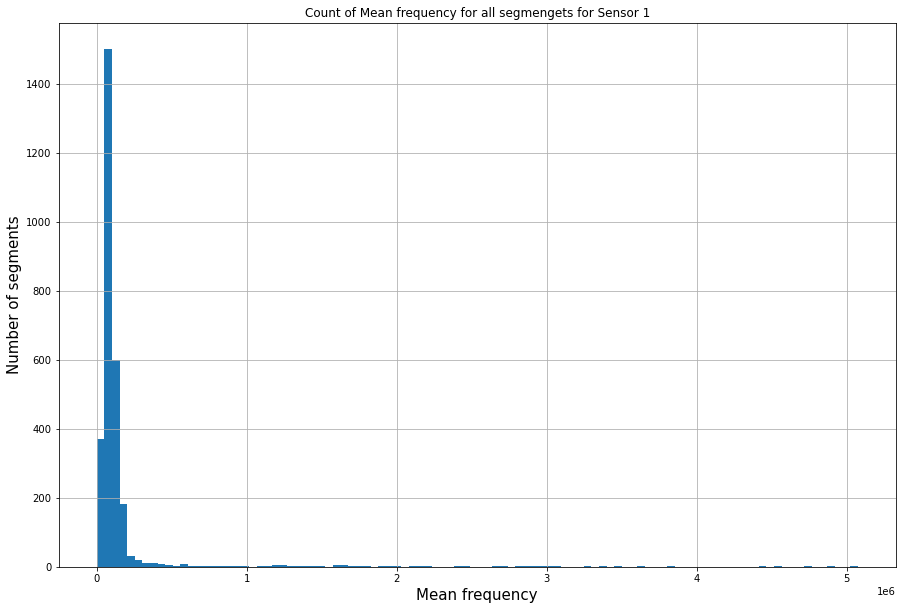

In [10]:
sensor_1 = X_train['sensor_1_std']
plt.figure(figsize=(15,10))
plt.title('Count of Mean frequency for all segmengets for Sensor 1')
#fig = sns.boxplot(data=sensor_1, palette="Set3")
#fig = sns.violinplot(data=sensor_1, palette="Set3", bw=.2, cut=1, linewidth=1, width=1)
plt.xlabel('Mean frequency', size=15)
plt.ylabel('Number of segments', size=15)
sensor_1.hist(bins=100)


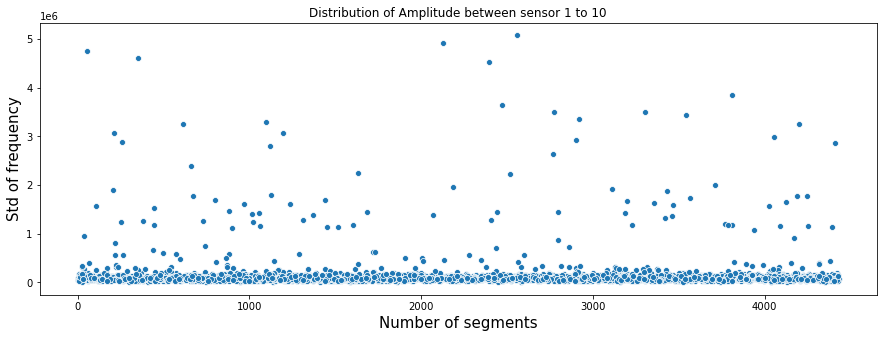

In [20]:
sensor_1 = X_train['sensor_1_std']
plt.figure(figsize=(15,5))
plt.title('Distribution of Amplitude between sensor 1 to 10')
plt.xlabel('Number of segments', size=15)
plt.ylabel('Std of frequency', size=15)
fig = sns.scatterplot(data=sensor_1)


### 3.5 Explain how your analysis relates to the objective of your project, i.e. why are these selected variables important?
Out dataset contains a set of 10 readings of seismic sensors plotted around a volcano. 


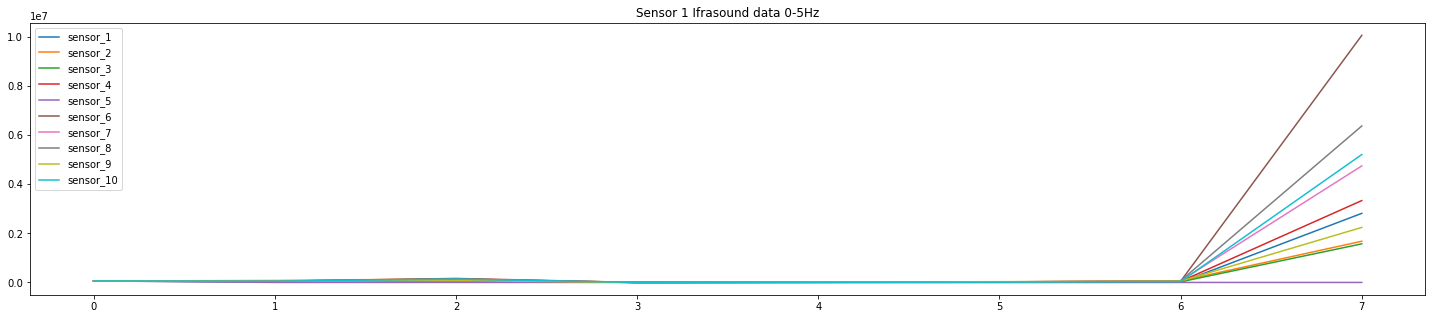

In [11]:
sensor_1 = df_seg_id
sensor_1.plot(figsize=(25, 5), title='Sensor 1 Ifrasound data 0-5Hz')

Our starting point was to find which if any sensor readings similar reading so that we can  we can remove redundant data and reduce the feature input. We look at the correlation between sensors and transformed data to a more useful state for the problem, modeling frequency over amplitude rather than amplitude over time. 

Using the correlation we estimated that some sensors are more correlated than others, and a low correlation would be more important to use as the sensors may be measuring different elements of LP events around an eruption. 
We will further examine which sensors to use after hypothesis testing on the standard deviation of frequency. 


## 4. Probability Distribution 

#### 4.1 Use probability distributions to describe some selected variables.



We plot the distribution of frequency of a sensor 'sensor 1' of a random segment.
We can see that the area under the curve between 0 and 0.5 is where the highest probabality of frequency occur. Sensor_data looks gaussian and right skewed.
The parameters are mean(mu) and standard deviation (sigma).
Below plot shows the signal at the median and mean around 0. 

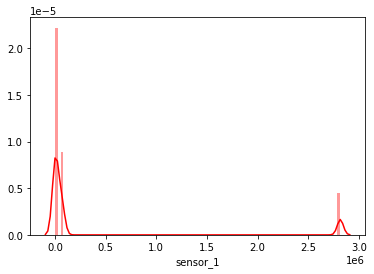

In [23]:
from scipy.fft import fft, fftshift, rfft, fftfreq

seg_id = train_df['segment_id'][0]
fft_raw_data = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/fft_stats/"+str(seg_id)+".csv")
signal_transform = fft_raw_data['sensor_1']
freq = 1000

xf = np.linspace(0, 1, freq)
fft_shift = signal_transform[:freq]

pdf = stats.norm.pdf(fft_shift, fft_shift.mean(), fft_shift.std())
ax = sns.distplot(fft_shift, kde=True, color='red', bins=100)
plt.show()


### 4.3 Hypothesis testing 
Our Null Hypothesis is that the sensor readings from two different samples(sensor1 and sensor9) show same readings. The experiment was done to collect the sensor readings from 10 different sensors across a segment. Each segment consists of a time interval of 10 mins. As the sample is taken from normal distribution the parameters of interest are Mean and std. deviation.

Null hypothesis: H0: mean_sensor_1=mean_sensor_9 H0: mu1-mu2=0, where mu1 is the mean of first sample and mu2 is the mean of second sample Alternative hypothesis: Ha: mean_sensor_1 is not equal to mean_sensor_9 Ha: mu-mu2 not equal to 0

We will run another test for the standard deviations: H'0: std1-std2=0, where std1 is the std deviation of first sample and std2 is the std. deviation of second sample H'a: std1-std2 is not equal to 0

We chose significance level as α=0.05 and then used the mean sensor data from consolidated file to run the tests. We have used scipy.stats ttest_ind to calculate the p_value.

If p_value < 0.05 i.e. the test statistic falls in the rejection regions of the null distribution then we reject the null hypothesis. If p_value > 0.05 then we do not reject the null hypothesis.


In [57]:
# Testing H0 for sensor 1 and 9
stats.ttest_ind(X_train[['sensor_1_mean','sensor_1_std']],X_train[['sensor_9_mean','sensor_9_std']])

# As per the test statistic p_value for both mean and std deviation is > 0.05 hence we "Do Not Reject the hypothesis"

Ttest_indResult(statistic=array([-1.21287448, -0.06361787]), pvalue=array([0.22522836, 0.94927675]))

In [58]:
# Testing H0 for sensor 1 and 4
stats.ttest_ind(df_consolidated[['sensor_1_mean','sensor_1_std']],df_consolidated[['sensor_4_mean','sensor_4_std']])

# As per the test statistic p_value for both mean and std deviation is > 0.05 hence we "Do Not Reject the hypothesis"

Ttest_indResult(statistic=array([-2.52575662,  0.3345197 ]), pvalue=array([0.01156223, 0.73799535]))

In [59]:
# Testing H0 for sensor 1 and 5
stats.ttest_ind(df_consolidated[['sensor_1_mean','sensor_1_std']],df_consolidated[['sensor_5_mean','sensor_5_std']])

# As per the test statistic p_value for both mean and std deviation is < 0.05 hence we "Reject the hypothesis"

Ttest_indResult(statistic=array([14.1618381 , 16.46582789]), pvalue=array([4.88185951e-45, 5.00510169e-60]))

### Conclusion from the test: 
As seen from above tests, sensor 1,9 and sensor 1,10 have mean and std deviations in the same range hence we should use likely use one of these two pairs of sensors in our training features.

Alternately, sensor 1 and 5 mean and std deviations are way apart hence both the sensors can be used for modelling purposes.


## 5. Predictive Analysis

### 5.1 Apply two predictive machine learning models to solve your problem.

Using SVM technique to classify the class for the time_of_eruption considering three classes:

class A : with time_of_eruption <= 2 days

class B : with time_of_eruption >2 days and <=4 days

class C : with time_of_eruption >4 days


In [60]:
# Added new column to display days_to_eruption by converting time in centiseconds to days
df_consolidated['days_to_eruption']=round(df_consolidated['time_to_eruption']/(100*60*60*24))
df_consolidated.tail()


,segment_id,time_to_eruption,sensor_1_mean,sensor_1_std,sensor_2_mean,sensor_2_std,sensor_3_mean,sensor_3_std,sensor_4_mean,sensor_4_std,...,sensor_6_std,sensor_7_mean,sensor_7_std,sensor_8_mean,sensor_8_std,sensor_9_mean,sensor_9_std,sensor_10_mean,sensor_10_std,days_to_eruption
4426,873340274,15695097,50223.301755,141617.748867,111255.219243,201801.896226,34948.644869,125600.912238,41841.022516,127163.720131,...,372878.629336,11662.787792,7133.942958,9971.286470,10995.199089,40876.682013,134532.465336,74634.441766,247038.795812,2.0
4427,1297437712,35659379,51042.947194,150591.550806,0.000000,0.000000,50213.070458,139171.703767,118647.115181,240806.411420,...,159373.634391,35959.514183,123025.979082,34374.990167,95211.442776,127785.476955,222184.038374,121864.818981,288873.017460,4.0
4428,694853998,31206935,10032.737288,25258.098586,72469.377624,100467.326918,10019.287227,23466.245504,13543.150565,30696.768354,...,48987.248398,17912.134813,34154.940533,26676.770282,47176.574966,13591.706198,31420.603934,21923.450433,57589.181288,4.0
4429,1886987043,9598270,72848.367371,91930.914799,0.000000,0.000000,17818.282503,56716.251551,25507.746813,69240.813210,...,111428.081922,15580.404866,81665.205386,0.000000,0.000000,25226.962009,67916.554529,50373.320177,137385.713183,1.0
4430,1100632800,20128938,18884.277615,64064.019529,49003.558585,94161.222230,18685.681320,50615.854407,21306.468340,50727.632690,...,63727.149200,75719.833186,96392.379185,41575.455743,67972.484019,20072.795819,56885.966386,49341.541613,183350.645600,2.0


In [61]:
# Create a new column to identify the classes based on the days of eruption
# 'A' for days_to_eruption <=2
# 'B' for days_to_eruption >=2 and <4
# 'C' for days_to_eruption >4

def classes(x):
    classValue = ""
    if x<=2:
        classValue = "A"
    elif (x>2 and x<=4):
        classValue = "B"
    else:
        classValue = "C"
    
    return classValue   
    
    
df_consolidated['class']=df_consolidated['days_to_eruption'].apply(classes) # creates new column 
df_consolidated.to_csv("../../predict-volcanic-eruptions-ingv-oe/fft_stats/dataset_updated.csv")
#df_consolidated=df_consolidated.fillna(0)
#df_consolidated.tail(10)


In [62]:
df_consolidated = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/fft_stats/dataset_updated.csv",index_col=0)
df_consolidated.head()

,segment_id,time_to_eruption,sensor_1_mean,sensor_1_std,sensor_2_mean,sensor_2_std,sensor_3_mean,sensor_3_std,sensor_4_mean,sensor_4_std,...,sensor_7_mean,sensor_7_std,sensor_8_mean,sensor_8_std,sensor_9_mean,sensor_9_std,sensor_10_mean,sensor_10_std,days_to_eruption,class
0,1136037770,12262005,18839.763682,71814.619373,79794.038063,145748.089214,28833.992366,65160.119783,44581.879703,82865.343224,...,54631.182062,115377.445256,58083.813580,140575.444552,52345.573275,74702.584192,49209.865872,137673.667436,1.0,A
1,1969647810,32739612,30404.978085,102982.692327,68742.438608,146640.433986,28896.048463,83886.472262,30526.271395,85202.640805,...,28416.753451,113033.350623,29933.747263,84245.069773,34104.585203,93136.969607,71044.259618,217193.391266,4.0,B
2,1895879680,14965999,18382.472061,56249.752906,89613.013241,182899.730150,17537.421286,50435.488236,44777.153392,56268.741569,...,14224.053140,86120.006114,20014.851868,83451.017032,27638.476061,57748.824526,40710.217592,115653.225881,2.0,A
3,2068207140,26469720,16290.547583,51876.076170,45764.101203,93557.323383,17044.619943,44386.272091,24853.055718,53167.331835,...,31395.069065,64420.740212,40074.373363,67904.639223,25061.671514,51263.329740,44153.732274,120394.720826,3.0,B
4,192955606,31072429,18969.185026,61231.679644,0.000000,0.000000,18090.572459,52820.180782,23665.943643,59809.638031,...,17024.966555,74658.159083,26592.077188,97508.159726,44452.939180,66069.326647,46900.506444,129624.851283,4.0,B


In [69]:

X=df_consolidated.drop(['segment_id','time_to_eruption','days_to_eruption','sensor_9_mean','sensor_9_std','sensor_4_mean','sensor_4_std','class'], axis='columns')
#X = df_consolidated[['sensor_1_mean','sensor_2_mean','sensor_10_mean','sensor_1_std','sensor_2_std','sensor_10_std']]
#X = df_consolidated[['sensor_1_mean','sensor_5_mean','sensor_2_mean','sensor_9_mean','sensor_1_std','sensor_5_std','sensor_2_std','sensor_9_std']]

y = df_consolidated['class']
X.head()
X.describe()

,sensor_1_mean,sensor_1_std,sensor_2_mean,sensor_2_std,sensor_3_mean,sensor_3_std,sensor_5_mean,sensor_5_std,sensor_6_mean,sensor_6_std,sensor_7_mean,sensor_7_std,sensor_8_mean,sensor_8_std,sensor_10_mean,sensor_10_std
count,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4.431000e+03,4431.000000,4.431000e+03,4431.000000,4.431000e+03,4.431000e+03,4.431000e+03
mean,4.710214e+04,1.512577e+05,1.003843e+05,2.164970e+05,3.968028e+04,1.381878e+05,2.435358e+04,5.612169e+04,6.007037e+04,1.887778e+05,42096.945296,1.204249e+05,43826.545034,1.256443e+05,7.568705e+04,2.468783e+05
std,9.843903e+04,3.587203e+05,1.592878e+05,4.107054e+05,8.741314e+04,3.421257e+05,4.174954e+04,1.387048e+05,5.694702e+04,2.895516e+05,40129.337852,1.964242e+05,38504.810783,1.838850e+05,1.216187e+05,4.284479e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.036785e+04,3.704347e+04,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.071513e+04,6.320366e+04,4.523750e+04,8.658093e+04,1.726674e+04,4.977809e+04,1.507091e+04,2.720638e+04,3.001792e+04,8.104247e+04,18868.128542,6.862641e+04,23644.743887,6.264635e+04,4.500474e+04,1.332802e+05
50%,2.659238e+04,8.300475e+04,6.691621e+04,1.225128e+05,2.296021e+04,7.051089e+04,2.053850e+04,4.109268e+04,4.444143e+04,1.288182e+05,33789.790054,9.474383e+04,38888.827382,1.013913e+05,5.449761e+04,1.674829e+05
75%,3.980716e+04,1.263383e+05,1.116011e+05,2.188086e+05,3.634625e+04,1.212257e+05,2.486925e+04,5.174308e+04,6.871451e+04,1.782020e+05,55547.355637,1.232634e+05,58270.579582,1.420191e+05,7.071096e+04,2.286731e+05
max,2.088111e+06,5.072697e+06,2.559920e+06,5.082422e+06,1.742853e+06,4.868468e+06,1.124848e+06,3.230481e+06,1.257390e+06,5.933612e+06,879603.679921,4.042831e+06,673306.302205,4.086952e+06,2.680672e+06,5.729546e+06


In [70]:
# Put a testing set aside and do not look at it before you test your model. 
# Split the rest of the data into a training set and a validation set.

# First split data to train, test and then split train again into validation and train.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train),len(X_test))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)  
print(len(X_train),len(X_val),len(X_test))

3544 887
2835 709 887


In [65]:

X_train.head()
#X_test.head()

,sensor_1_mean,sensor_1_std,sensor_2_mean,sensor_2_std,sensor_3_mean,sensor_3_std,sensor_4_mean,sensor_4_std,sensor_5_mean,sensor_5_std,sensor_6_mean,sensor_6_std,sensor_7_mean,sensor_7_std,sensor_8_mean,sensor_8_std,sensor_10_mean,sensor_10_std
790,21586.650674,62636.873623,0.000000,0.000000,19314.453473,58787.450365,31899.200881,80822.049853,20728.865700,45461.249143,59529.151204,155311.526189,124759.702202,174942.612968,51824.681512,137754.376261,54021.924534,137998.263175
708,20487.587172,58966.287608,0.000000,0.000000,18499.977069,55335.139727,31791.322485,72444.725183,25956.688717,55323.633537,18856.406980,88265.160224,18667.135872,66648.580630,23645.725205,111683.323819,52764.596176,150034.916542
3850,27477.379148,95583.483723,99370.361600,184442.728594,67796.827057,252034.510610,42400.058605,96456.698433,0.000000,0.000000,91387.315255,176069.590469,50037.942155,142409.517410,54096.490491,166409.654471,93524.344999,170550.269546
801,35783.256401,119937.978398,183003.683552,375126.068020,35082.398960,111630.263761,48295.257209,141892.878776,35966.847555,79704.253655,38305.156956,145815.973049,31887.706365,107315.384893,30543.151195,75428.953015,78938.747217,242732.397621
2195,20406.649001,59630.512893,0.000000,0.000000,18790.238635,54121.720386,28028.812447,71143.167594,24509.130373,52694.128729,19216.381277,89431.789209,14479.435892,64344.979056,23952.791661,109924.910633,52160.215721,145528.326648


## 5.2 For each model, state the following:

### What is the name of the model?

SVM - Support Vector Machine is a set of supervised learning method used for classification, Regression and outlier detection. It is effective in high dimension spaces. It looks at the data and divides it into 2 or more categories.

### What is the mathematical expression of the model?


C - It controls the trade off between smooth decision boundary and classifying training points correctly. A large value of C means we will get more training points correctly. If C is small, the penalty for misclassified points is low so a decision boundary with a large margin is chosen at the expense of a greater number of misclassifications. 
By default its 1.
 
gamma - Low values of gamma indicates a large similarity radius which results in more points being grouped together. For high values of gamma, the points need to be very close to each other in order to be considered in the same group (or class).

For a linear kernel, we just need to optimize the c parameter. However, if we want to use an RBF kernel, both c and gamma parameter need to optimized simultaneously.

The parametrs are what will be learned, which are the boundaries for data.


Reference: https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167



In [39]:
# Fitting the training data into the SVC model
model=SVC()
model.fit(X_train,y_train)
# Calculating the score for test data
model.score(X_val, y_val)

0.5937940761636107

0.593010146561443


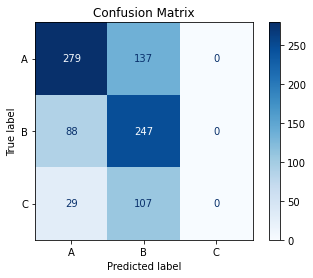

Accuracy: 0.593010146561443
Precision: 0.593010146561443
Recall: 0.593010146561443
F1 score: 0.593010146561443


In [40]:
from sklearn.metrics import plot_confusion_matrix

print(model.score(X_test, y_test))

# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()
#print(pd.Index(y_test).value_counts())

y_test_pred= model.predict(X_test)
#pd.crosstab(y_test, y_test_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

calculateMetrics(y_test, y_test_pred)

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def calculateMetrics(y_test, y_test_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_test_pred)
    print('Accuracy:', accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_test_pred,average='micro')
    print('Precision:',precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_test_pred,average='micro')
    print('Recall:',recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_test_pred,average='micro')
    print('F1 score:',f1)


In [72]:
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix

model1= tree.DecisionTreeClassifier()
model1.fit(X_train,y_train)

# Calculating the score for validation data
model1.score(X_val, y_val)


0.7785613540197461

0.7824126268320181


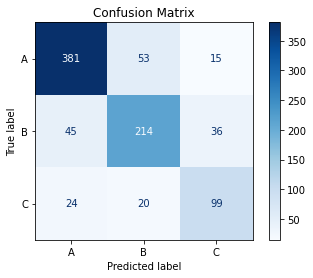

Accuracy: 0.7824126268320181
Precision: 0.7824126268320181
Recall: 0.7824126268320181
F1 score: 0.7824126268320181


In [73]:
print(model1.score(X_test, y_test))

disp = plot_confusion_matrix(model1, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()

y_test_pred= model1.predict(X_test)
pd.crosstab(y_test, y_test_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

calculateMetrics(y_test, y_test_pred)

In [53]:
from sklearn.neighbors import NearestCentroid
model2= NearestCentroid()
model2.fit(X_train,y_train)

# Calculating the score for test data
model2.score(X_val, y_val)

0.3018335684062059

0.32919954904171367


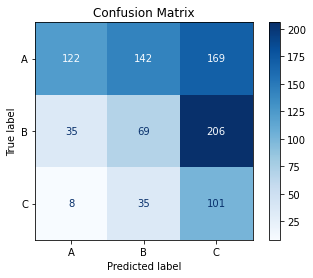

Accuracy: 0.32919954904171367
Precision: 0.32919954904171367
Recall: 0.32919954904171367
F1 score: 0.32919954904171367


In [29]:
print(model2.score(X_test, y_test))

disp = plot_confusion_matrix(model2, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()

y_test_pred= model2.predict(X_test)
pd.crosstab(y_test, y_test_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

calculateMetrics(y_test, y_test_pred)

### What is the name of the model?

Guassian Naive Bayes classifier

### What are the hyperparameters?
It does not have any parameters to tune.


In [30]:
model3= GaussianNB()
model3.fit(X_train, y_train)
model3.score(X_val,y_val)

0.2637517630465444

0.2717023675310034


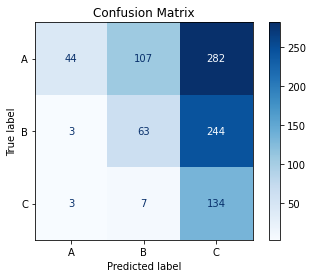

Accuracy: 0.2717023675310034
Precision: 0.2717023675310034
Recall: 0.2717023675310034
F1 score: 0.2717023675310034


In [31]:
print(model3.score(X_test, y_test))

disp = plot_confusion_matrix(model3, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()

y_test_pred= model3.predict(X_test)
pd.crosstab(y_test, y_test_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

calculateMetrics(y_test, y_test_pred)

### Evaluate their performance. 
From our test, our base test for Gaussian performed poorly, SVC was only slighly better, experimening we found Desicion Tree improved the result with about 70 % score on out validation set. 

# Conclusion
Our goal was to build an early warning system by creating a predictive model to infer on seismic LP event data. Such data is continually monitored around a volcanos and could potentially be passed to a one such model for analysis. 
We had access to data from 10 sensors around a volcano, each of 60,000 timesteps at sampling frequency of 100Hz, 10 min of data per time segment. Each we a total of 4431 segment files.

We decided to process the raw data using a fast-Fourier transform and reduce the dimensionality of data using the mean and standard deviation of the frequency and amplitude for each segment. After analysis of the sensor data we further eliminated the number of features, by reducing the sensor input to 3 sensors. These three sensors were chosen that proves the our null hypothesis wrong, such that the sensor data was statically different form each other. 

We choose to predict several classes instead of a continuous value to reduce the complexity of the problem but hindsight we could chosen a regression model entirely as we already had a time to eruption data. We hoped however that predict a class, i,e, 0-2 days, 2-4 days, 4+ days should be a easier task. 

We choose two models, SVC and Gaussian as both are appropriate classification models. Gaussian was chosen as a base model and SVC due to being able to handle higher dimensionality well. The input data of our dataset is already known to a complex problem proposed by the INGV, that is to interpret the LP volcanic-earthquake events. With our current approach, our models have not yielded interpretable results, with  a model score around 50 percent. This maybe that the dimension is now too low, using just the standard deviation and one could include the min and max quantiles. Further we propose to use an LSTM model that is well known to model time-series data.        




#### References
[1] https://www.usgs.gov/natural-hazards/volcano-hazards/monitoring-volcano-seismicity-provides-insight-volcanic-structure
[2] Multidisciplinary investigation on a lava fountain preceding a flank eruption: The 10 May 2008 Etna case, A. Bonaccorso, 2008
[4] https://www.pbs.org/wgbh/nova/volcano/seis_lpe.html#:~:text=LP%20events%20are%20volcano%2Drelated,of%20pressure%20within%20a%20volcano
